⬇️ Downloading price data. This may take a few minutes...

✅ Optimal Portfolio Allocation (all stocks):
Ticker
WMB     0.004109
NVDA    0.004104
ISRG    0.004095
IRM     0.004091
FCX     0.004085
          ...   
XYL     0.000044
ALLE    0.000031
BBY     0.000020
DVN     0.000013
ROK     0.000008
Length: 490, dtype: float64


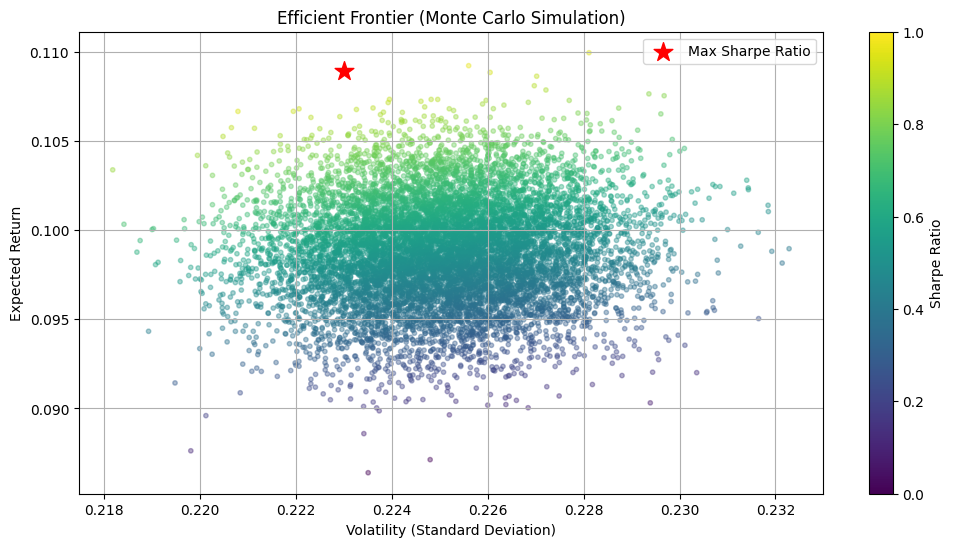

In [4]:
# 📊 Modern Portfolio Theory (MPT) Optimizer for S&P 500 Stocks
# This notebook downloads historical price data for S&P 500 stocks,
# calculates their log returns, and builds an optimal portfolio allocation
# using Monte Carlo simulation and Modern Portfolio Theory (MPT).

# 🧰 Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 📌 Step 1: Get the list of S&P 500 tickers from Wikipedia
def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url)
    tickers = table[0]['Symbol'].tolist()
    tickers = [ticker.replace('.', '-') for ticker in tickers]  # Adjust for yfinance
    return tickers

# 📌 Step 2: Download historical price data (adjusted close) from Yahoo Finance
def download_price_data(tickers, start='2020-01-01', end='2025-01-01'):
    print("⬇️ Downloading price data. This may take a few minutes...")
    data = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)['Close']
    data = data.dropna(axis=1, how='any')  # drops all tickers with missing data

    return data

# 📌 Step 3: Calculate daily logarithmic returns
def calculate_log_returns(data):
    return np.log(data / data.shift(1)).dropna()

# 📌 Step 4: Monte Carlo simulation to find optimal portfolio (max Sharpe Ratio)
def optimize_portfolio(returns, num_portfolios=10000, risk_free_rate=0.01):
    np.random.seed(42)
    num_assets = returns.shape[1]
    mean_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252

    results = np.zeros((4, num_portfolios))
    weight_array = []

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weight_array.append(weights)

        portfolio_return = np.dot(weights, mean_returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        # Avoid divide-by-zero
        if portfolio_stddev == 0:
            results[:, i] = [0, 0, -np.inf, i]
            continue

        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev

        results[0, i] = portfolio_return
        results[1, i] = portfolio_stddev
        results[2, i] = sharpe_ratio
        results[3, i] = i

    max_sharpe_idx = np.argmax(results[2])
    optimal_weights = weight_array[int(results[3, max_sharpe_idx])]

    return results, weight_array, optimal_weights, mean_returns.index

# 📌 Step 5: Display optimal allocation (show only weights > 1%)
def display_optimal_portfolio(optimal_weights, tickers):
    portfolio = pd.Series(optimal_weights, index=tickers)
    print("\n✅ Optimal Portfolio Allocation (all stocks):")
    print(portfolio.sort_values(ascending=False))

    # Save full portfolio
    portfolio.to_csv("optimal_portfolio_full.csv")
    return portfolio


# 🧪 Run the full workflow
def main():
    # Get all S&P 500 tickers
    tickers = get_sp500_tickers()
    tickers_subset = tickers  # Use all tickers

    # Download stock price data
    data = download_price_data(tickers_subset)

    if data.shape[1] < 2:
        print("❌ Not enough tickers with valid data to build a portfolio.")
        return

    # Calculate returns and optimize portfolio
    returns = calculate_log_returns(data)
    results, weight_array, optimal_weights, selected_tickers = optimize_portfolio(returns)

    # Display allocation
    selected = display_optimal_portfolio(optimal_weights, selected_tickers)

    # Plot the efficient frontier
    plt.figure(figsize=(12, 6))
    plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', s=10, alpha=0.4)
    max_idx = np.argmax(results[2])
    plt.scatter(results[1, max_idx], results[0, max_idx], color='red', marker='*', s=200, label='Max Sharpe Ratio')
    plt.title('Efficient Frontier (Monte Carlo Simulation)')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

# ▶️ Run the main function
main()
